In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import r2_score
import io
import requests

In [4]:
dataset =pd.read_csv("./data/advertising.csv")
dataset.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [6]:
#checking the number of null data
dataset.isnull().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

In [7]:
# We calculate Pearson correlation coefficients
# between advertisements of different media
# and the mount of sales
tv_corr = stats.pearsonr(dataset['TV'], dataset['Sales'])
radio_corr = stats.pearsonr(dataset['Radio'], dataset['Sales'])
newspaper_corr = stats.pearsonr(dataset['Newspaper'], dataset['Sales'])

In [8]:
print(f"Pearson c. tv-sales: {tv_corr}")
print(f"Pearson c. radio-sales: {radio_corr}")
print(f"Pearson c. newspaper-sales: {newspaper_corr}")

Pearson c. tv-sales: PearsonRResult(statistic=0.9012079133023309, pvalue=7.927911625319444e-74)
Pearson c. radio-sales: PearsonRResult(statistic=0.34963109700766926, pvalue=3.882892364493946e-07)
Pearson c. newspaper-sales: PearsonRResult(statistic=0.1579600261549263, pvalue=0.025487444306996235)


TV    Axes(0.125,0.712609;0.775x0.167391)
dtype: object

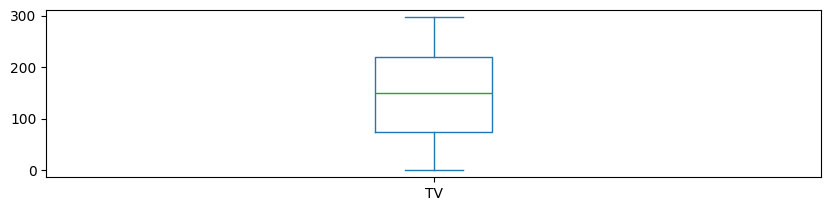

In [9]:

# Pearson correlation between Tv and Sales is the highest.
# We choose TV
# Whether TV data contain outliers or not from box plot
dataset["TV"].plot(
    kind="box",
    subplots=True,
    layout=(4,1),
    figsize=(10,10)
)

In [10]:
# String data from dataset into variable
tv = dataset["TV"]
sales = dataset["Sales"]

# maximun values
tv_max = tv.max()
sales_max = sales.max()

# minimum values
tv_min = tv.min()
sales_min = sales.min()

# range values
tv_range = tv_max - tv_min

# mean values
tv_mean = np.mean(tv)
sales_mean = np.mean(sales)

# standar desviation
tv_std = np.std(tv)
sales_std = np.std(sales)


In [11]:
# Applying standard scaling on tv data
# this scaled data will be used input data

def standard_scaling(x: np.ndarray):
    return (x - np.mean(x)) / (np.std(x) + 1e-10)

In [12]:
tv = standard_scaling(tv)

In [13]:
tv

0      0.969852
1     -1.197376
2     -1.516155
3      0.052050
4      0.394182
         ...   
195   -1.270941
196   -0.617035
197    0.349810
198    1.594565
199    0.993206
Name: TV, Length: 200, dtype: float64

In [14]:
tv = np.array(tv)
tv = np.reshape(tv, (len(tv), 1))
tv[0:10]

array([[ 0.96985227],
       [-1.19737623],
       [-1.51615499],
       [ 0.05204968],
       [ 0.3941822 ],
       [-1.61540845],
       [-1.04557682],
       [-0.31343659],
       [-1.61657614],
       [ 0.61604287]])

Equation for simple linear regression is:

$y = ϴ_0 + ϴ_1 x $.

In our case,
y = Sales and x = TV

$sales = ϴ_0  + ϴ_1 TV$


In [15]:
X_ones = np.ones((len(tv), 1))
X_ones[0:5]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [16]:
X = np.concatenate((X_ones, tv), axis=1)
X[0:5] #input data columns

array([[ 1.        ,  0.96985227],
       [ 1.        , -1.19737623],
       [ 1.        , -1.51615499],
       [ 1.        ,  0.05204968],
       [ 1.        ,  0.3941822 ]])

In [17]:
y_true = np.array(sales)
y_true[0:5]

array([22.1, 10.4, 12. , 16.5, 17.9])

In [18]:
y_true = np.reshape(y_true, (len(y_true), 1))
y_true[0:5] # the sales data are stored as output

array([[22.1],
       [10.4],
       [12. ],
       [16.5],
       [17.9]])

In [19]:
# defining MSE function
def loss_mse(y_true: np.ndarray, y_pred: np.ndarray):
    loss = np.mean((y_true - y_pred) ** 2)
    return loss

In [20]:
# function for gradient calculation
def grad(X: np.ndarray, y_true: np.ndarray, y_pred: np.ndarray):
    grad_c = 2 * np.mean(y_pred - y_true)
    grad_m = 2 * np.mean((y_pred - y_true) * X)
    grad = np.array([grad_c, grad_m])
    return grad

In [21]:
def train(
      X: np.ndarray,
      y_true: np.ndarray,
      params: np.ndarray,
      learning_rate: float
    ):
    #Model prediction as y_hat
    y_hat = (params * X).sum(axis=1)
    y_hat = np.reshape(y_hat, (len(y_hat), 1))
    #Loss calculation
    loss = loss_mse(y_true, y_hat)
    #Gradient calculation
    gradient = grad(X, y_true, y_hat)
    new_params = params - learning_rate * gradient
    return loss, new_params


In [22]:
# Splitting the dataset
X_train = X[:180]
X_test = X[180:]
y_train = y_true[:180]
y_test = y_true[180:]

In [23]:
# Number of iterations or epoch
epoch = 50
alpha = 0.1
losses = []
params = np.ones((1,2), dtype=np.float64)
for i in range(epoch):
    loss, params = train(X_train, y_train, params, alpha)
    losses.append(loss)
    print(f"Epoch {i+1} loss: {loss}")

Epoch 1 loss: 217.740264560379
Epoch 2 loss: 136.62414034075607
Epoch 3 loss: 87.52547343921952
Epoch 4 loss: 57.858608931878756
Epoch 5 loss: 39.91014564917161
Epoch 6 loss: 28.983105242718597
Epoch 7 loss: 22.238101941431413
Epoch 8 loss: 17.972700755715614
Epoch 9 loss: 15.17539976190225
Epoch 10 loss: 13.251108937575928
Epoch 11 loss: 11.8532787001845
Epoch 12 loss: 10.782029159628713
Epoch 13 loss: 9.922891362914871
Epoch 14 loss: 9.210369802085966
Epoch 15 loss: 8.606553398958242
Epoch 16 loss: 8.088761809961902
Epoch 17 loss: 7.6425527654052186
Epoch 18 loss: 7.25786395507824
Epoch 19 loss: 6.9269539148156785
Epoch 20 loss: 6.643350783835581
Epoch 21 loss: 6.401347646473746
Epoch 22 loss: 6.195780935977586
Epoch 23 loss: 6.0219454155430325
Epoch 24 loss: 5.875567373416124
Epoch 25 loss: 5.752796463610946
Epoch 26 loss: 5.650198069050545
Epoch 27 loss: 5.564739420018494
Epoch 28 loss: 5.493768321761294
Epoch 29 loss: 5.434985807015034
Epoch 30 loss: 5.386414829935716
Epoch 31 los

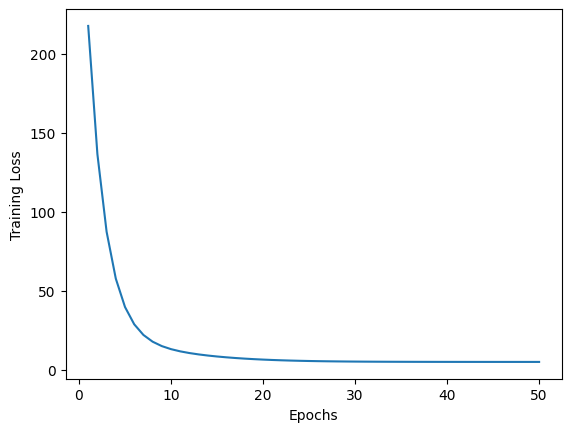

In [24]:
fig = plt.figure()
epochs = np.arange(1, epoch+1)
plt.plot(epochs, losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

In [25]:
# Calculation of training R2 score
train_pred = (params * X_train).sum(axis=1)
train_pred = np.reshape(train_pred, (len(train_pred), 1))
train_r2 = r2_score(y_train, train_pred)
print(f"Training R2 score: {train_r2}")

Training R2 score: 0.8092780604137841


In [26]:
test_r2 = r2_score(y_test, (params * X_test).sum(axis=1))
print(f"Test R2 score: {test_r2}")

Test R2 score: 0.8324002954506058


Text(0, 0.5, 'Sales')

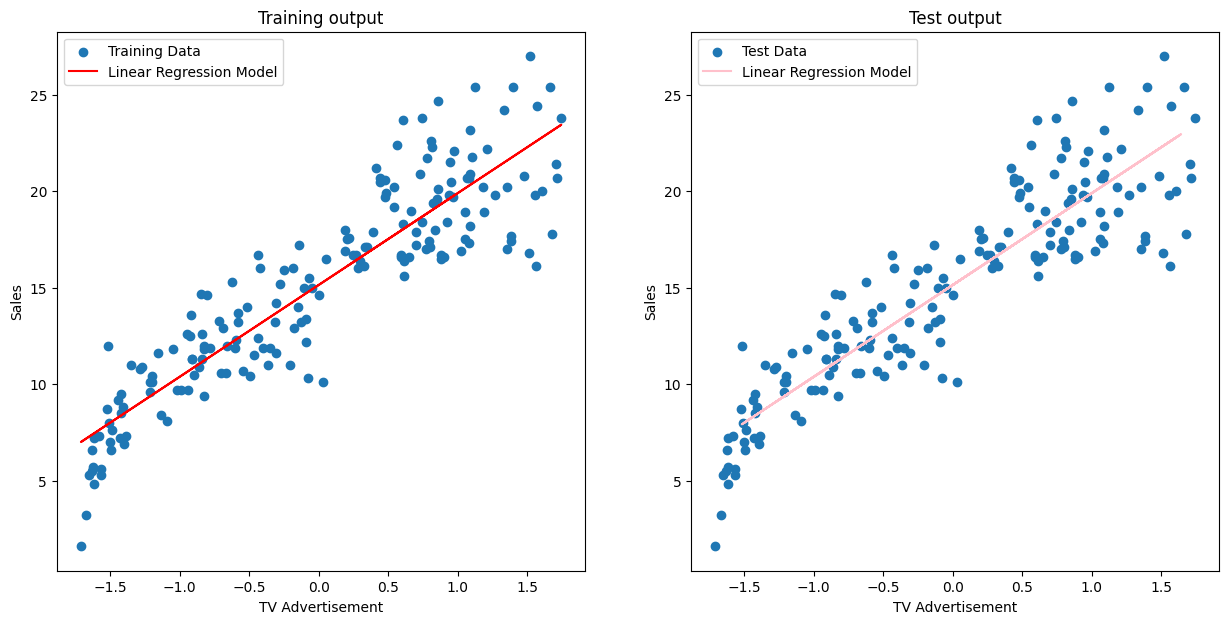

In [27]:
# subplot to linear regression ouput
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
x = X_train[:, 1]
y = params[:, 0] + params[:, 1] * x
ax1.scatter(tv[:180], sales[:180], label="Training Data")
ax1.plot(x, y, label="Linear Regression Model", color="red")
ax1.legend()
ax1.set_title("Training output")
ax1.set_xlabel("TV Advertisement")
ax1.set_ylabel("Sales")
x = X_test[:, 1]
y = params[:, 0] + params[:, 1] * x
ax2.scatter(tv[:180], sales[:180], label="Test Data")
ax2.plot(x, y, label="Linear Regression Model", color="pink")
ax2.legend()
ax2.set_title("Test output")
ax2.set_xlabel("TV Advertisement")
ax2.set_ylabel("Sales")
